In [2]:
import pandas as pd
import numpy as np
import os
import sys

# RegulonDB Database

In [3]:
# Read the table of Regulatory interaction set from RegulonDB
RI_Set_df = pd.read_csv('../files/RISet.tsv', sep='\t', skiprows=44)
# RI_Set_df.head()

# Extract the columns directly
regDB_df = RI_Set_df[['4)regulatorName', '7)tfrsLeft', '8)tfrsRight', '9)strand', '10)tfrsSeq', '14)tss', '17)firstGene', '19)targetTuOrGene']].copy()
regDB_df.columns = ['TF', 'Start_tfrs', 'End_tfrs', 'Strand', 'TFRS', 'TSS', 'First_gene', 'TU/ gene']
regDB_df['TFRS_upper'] = regDB_df['TFRS'].str.extract('([A-Z]+)')
regDB_df['TU/ gene'] = regDB_df['TU/ gene'].str.split(':').str[1]

regDB_df.head()

,TF,Start_tfrs,End_tfrs,Strand,TFRS,TSS,First_gene,TU/ gene,TFRS_upper
0,GadW,3653866.0,3653885.0,forward,atcagacaggTTTACGTTACTATCAGGCATatcacctcag,3653936.0,slp,slp-dctR,TTTACGTTACTATCAGGCAT
1,GadW,3656835.0,3656854.0,reverse,tgaaataaaaATATCTGATTTTGATATTTTccatcaacat,3656791.0,hdeA,hdeAB-yhiD,ATATCTGATTTTGATATTTT
2,GalR,3088004.0,3088019.0,forward,atcatcacaaCTGAAACCGATTACACcaaccacaac,3088255.0,galP,galP,CTGAAACCGATTACAC
3,GalS,3088004.0,3088019.0,forward,atcatcacaaCTGAAACCGATTACACcaaccacaac,3088255.0,galP,galP,CTGAAACCGATTACAC
4,GalR,3088069.0,3088084.0,forward,ttattcggttTTCACAGTTGTTACATttcttttcag,3088255.0,galP,galP,TTCACAGTTGTTACAT


In [4]:
genes_df = pd.read_csv('genes.csv')

print('Number of genes from GenBank:', len(genes_df))
genes_df.head()

Number of genes from GenBank: 4506


,start,end,strand,gene_locus,gene_name
0,189,255,1,b0001,thrL
1,336,2799,1,b0002,thrA
2,2800,3733,1,b0003,thrB
3,3733,5020,1,b0004,thrC
4,5233,5530,1,b0005,yaaX


In [5]:
# Extract unique genes, their TSS, and strand
gene_tss = regDB_df[['First_gene', 'TSS', 'Strand']].drop_duplicates()

def get_gene_tfs_with_distance(gene_tss_df, regDB_df, upstream_distance=500):
    gene_tfs = []
    for idx, row in gene_tss_df.iterrows():
        gene = row['First_gene']
        tss = row['TSS']
        strand = row['Strand']
        
        if strand == 'forward':
            upstream_start = tss - upstream_distance
            upstream_end = tss
        elif strand == 'reverse':
            upstream_start = tss
            upstream_end = tss + upstream_distance
        else:
            continue
        
        mask = (
            (regDB_df['Start_tfrs'] <= upstream_end) & 
            (regDB_df['End_tfrs'] >= upstream_start)
        )
        
        matching_tfs = regDB_df[mask]

        # If I want the TFs and distaces in a list format
        # matching_tfs = regDB_df[mask]
        # tfs = matching_tfs['TF'].tolist()
        # distances = [abs(start - tss) for start in matching_tfs['Start_tfrs']]
        
        # TFs and distances each in a separate row
        for _, tf_row in matching_tfs.iterrows():
            tf = tf_row['TF']
            # Calculate distance from TSS to TF binding site start
            distance = abs(tf_row['Start_tfrs'] - tss)
            gene_tfs.append({
                'First_gene': gene,
                'Transcription_factors': tf,
                'Distances': distance
            })
    
    return pd.DataFrame(gene_tfs)

# Get the results
gene_tfs_500_with_distance = get_gene_tfs_with_distance(gene_tss, regDB_df, upstream_distance=500)

# Save the results to a CSV file
# gene_tfs_500_with_distance.to_csv('regDB_500_with_distance.csv', index=False)

# Show the first few rows
gene_tfs_500_with_distance.head()       # 856 unique genes and 225 TFs


,First_gene,Transcription_factors,Distances
0,slp,GadW,70.0
1,slp,GadX,91.0
2,slp,GadW,91.0
3,slp,YdeO,52.0
4,slp,GadX,13.0


### Results from RegulonDB 
856 unique genes and 225 TFs

# TEC Database

In [6]:
# Get the list of files in the folder
folder_path = '../files/schingen/tf_list/'
files = os.listdir(folder_path)

# Filter out only the csv files
csv_files = [f for f in files if f.endswith('.csv')]

# Print the list of csv files
print(csv_files[:5])

# Read each csv file and store it in a dictionary with the file name as the key
tf_dict = {}
for file in csv_files:
    tf_name = file.split('.')[0]  # Get the file name without the extension
    tf_df = pd.read_csv(os.path.join(folder_path, file))
    tf_dict[tf_name] = tf_df  

# tf_dict

['MntR.csv', 'CusRAcP.csv', 'Cra.csv', 'LacI.csv', 'CRP.csv']


In [7]:
# Filter tf_dict to only include significant rows
import scipy.stats as stats

# Process each transcription factor DataFrame
for tf_name, tf_df in tf_dict.items():
    # Extract binding intensities for the current TF
    binding_intensity = tf_df[tf_name].values
    
    # Calculate z-scores
    mean = np.mean(binding_intensity)
    std = np.std(binding_intensity, ddof=1)
    z_scores = (binding_intensity - mean) / std

    # p_values = 1 - stats.norm.cdf(z_scores)  # Right tailed p-value targeting the higher than mean binding intensities
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))   # Two-tailed p-value capturing both sides of the distribution

    # Apply significance threshold (e.g., p < 0.05)
    significant_mask = p_values < 0.05

    # Another significance threshold
    # significance_threshold = mean + 2 * std
    # tf_dict[tf_name] = tf_df[tf_df[tf_name] > significance_threshold]
    
    # Filter significant rows
    tf_dict[tf_name] = tf_df[significant_mask]  #.reset_index(drop=True)

# tf_dict

# tf_dict['CRP']['CRP'].nlargest(345)     # Check top 345 in CRP according to the number of peaks in a paper
# len(tf_dict['CRP'][tf_dict['CRP']['CRP'] > 4.0])   # Using 4.0 as a threshold based on another supplementary material from a paper

In [ ]:
# Function to get transcription factors for genes with distance
def shigen_get_gene_tfs_with_distance(gene_tss, tf_dict, upstream_distance=500):
    gene_tfs = []
    for idx, row in gene_tss.iterrows():
        gene = row['First_gene']
        tss = row['TSS']
        strand = row['Strand']
        
        if strand == 'forward':
            upstream_start = tss - upstream_distance
            upstream_end = tss
        elif strand == 'reverse':
            upstream_start = tss
            upstream_end = tss + upstream_distance
        else:
            continue
        
        for tf_name, tf_df in tf_dict.items():
            # Filter binding sites within the upstream region
            in_region = (tf_df['center'] >= upstream_start) & (tf_df['center'] <= upstream_end)
            matching_sites = tf_df.loc[in_region]
            
            for _, site in matching_sites.iterrows():
                # Calculate distance from TSS to TF binding site center
                distance = abs(site['center'] - tss)
                gene_tfs.append({
                    'First_gene': gene,
                    'Transcription_factors': tf_name,
                    'Distances': distance,
                    'binding_intensity': site[tf_name]
                })
    
    result_df = pd.DataFrame(gene_tfs)
    return result_df

shi_result_df = shigen_get_gene_tfs_with_distance(gene_tss, tf_dict, upstream_distance=500)

# shi_result_df.to_csv('shigen_500_with_distance_and_intensity.csv', index=False)

# ECOCYC DATABASE

In [9]:
# Load the TF binding data from the Ecocyc
ecocyc_df = pd.read_csv('../files/ecocyc/ecocyc_tf_binding.csv')
ecocyc_id_map = pd.read_csv('../files/ecocyc/ecocyc_transcription_id.csv')

ecocyc_df.columns = ['TF_ids', 'center','site_length']

# Convert column to int and drop NaN values
ecocyc_df['center'] = np.ceil(pd.to_numeric(ecocyc_df['center'], errors='coerce')).astype('Int64')
ecocyc_df = ecocyc_df.dropna(subset=['center'])
ecocyc_df = ecocyc_df[['TF_ids', 'center']]

# ecocyc_df.head()

In [10]:
# Map the ecocyc TF IDs to their common names
ecocyc_id_map = ecocyc_id_map[['DNA-Binding-Sites', 'Object ID']]
ecocyc_id_map.columns = ['binding', 'TF_ids']
ecocyc_id_map['TF_name'] = ecocyc_id_map['binding'].str.split(' ').str[0]

# After manual correction of TF names on ecocyc_id_map
ecocyc_id_curated_df = pd.read_csv('ecocyc_id_curated.csv')

# Map the TF binding IDs by merging the DFs such that the new DF wil have same rows as ecocyc_df (centers with NaN dropped)
ecocyc_mapped_df = ecocyc_df.merge(ecocyc_id_curated_df, on='TF_ids', how='left')

ecocyc_tf_data = ecocyc_mapped_df[['TF_name', 'center']].copy()
ecocyc_tf_data.head()

,TF_name,center
0,PhoB,1932837
1,CRP,1313949
2,ArgR,900675
3,CRP,161581
4,MelR,4341787


In [ ]:
# Function to get transcription factors for genes with distance from Ecocyc data
def ecocyc_get_gene_tfs_with_distance(gene_tss, ecocyc_df, upstream_distance=500):
    gene_tfs = []
    for idx, row in gene_tss.iterrows():
        gene = row['First_gene']
        tss = row['TSS']
        strand = row['Strand']
        
        if strand == 'forward':
            upstream_start = tss - upstream_distance
            upstream_end = tss
        elif strand == 'reverse':
            upstream_start = tss
            upstream_end = tss + upstream_distance
        else:
            continue
        
        # Filter binding sites within the upstream region
        in_region = (ecocyc_df['center'] >= upstream_start) & (ecocyc_df['center'] <= upstream_end)
        matching_sites = ecocyc_df[in_region]
        
        for _, site in matching_sites.iterrows():
            distance = abs(site['center'] - tss)
            gene_tfs.append({
                'First_gene': gene,
                'Transcription_factors': site['TF_name'],
                'Distances': distance
            })

    return pd.DataFrame(gene_tfs)


# Get the results from Ecocyc
ecocyc_gene_tfs_500_with_distance = ecocyc_get_gene_tfs_with_distance(gene_tss, ecocyc_tf_data, upstream_distance=500)

# ecocyc_gene_tfs_500_with_distance.head()
# ecocyc_gene_tfs_500_with_distance.to_csv('ecocyc_500_with_distance2.csv', index=False)


# Build consensus table

In [1]:
import pandas as pd

regDB = pd.read_csv('databases_data/regDB_500_with_distance.csv')
shigen = pd.read_csv('databases_data/shigen_500_with_distance.csv')
ecocyc = pd.read_csv('databases_data/ecocyc_500_with_distance.csv')

# Create sets of gene-TF pairs for each database
regDB_pairs_tf_gene = set(regDB[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))
shigen_pairs_tf_gene = set(shigen[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))
ecocyc_pairs_tf_gene = set(ecocyc[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))

In [3]:
len(regDB_pairs_tf_gene), len(shigen_pairs_tf_gene), len(ecocyc_pairs_tf_gene)

(2143, 122, 1591)

In [19]:
# Load the dataframes from the three databases
regDB = pd.read_csv('databases_data/regDB_500_with_distance.csv')
shigen = pd.read_csv('databases_data/shigen_500_with_distance.csv')
ecocyc = pd.read_csv('databases_data/ecocyc_500_with_distance.csv')

# Create sets of gene-TF pairs for each database
regDB_pairs_tf_gene = set(regDB[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))
shigen_pairs_tf_gene = set(shigen[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))
ecocyc_pairs_tf_gene = set(ecocyc[['First_gene', 'Transcription_factors']].apply(tuple, axis=1))

# Combine all unique pairs_tf_gene from the three databases
all_pairs_tf_gene = regDB_pairs_tf_gene.union(shigen_pairs_tf_gene).union(ecocyc_pairs_tf_gene)

# Convert the set of pairs_tf_gene into a DataFrame
combined_tf_gene_df = pd.DataFrame(list(all_pairs_tf_gene), columns=['genes', 'TF'])

# Check membership in each database and assign 1 or 0
combined_tf_gene_df['regDB'] = combined_tf_gene_df.apply(lambda row: 1 if (row['genes'], row['TF']) in regDB_pairs_tf_gene else 0, axis=1)
combined_tf_gene_df['shigen'] = combined_tf_gene_df.apply(lambda row: 1 if (row['genes'], row['TF']) in shigen_pairs_tf_gene else 0, axis=1)
combined_tf_gene_df['ecocyc'] = combined_tf_gene_df.apply(lambda row: 1 if (row['genes'], row['TF']) in ecocyc_pairs_tf_gene else 0, axis=1)

# combined_tf_gene_df.to_csv('databases_data/combined_gene_tf.csv', index=False)
combined_tf_gene_df.head()


,genes,TF,regDB,shigen,ecocyc
0,dmsA,FNR,1,0,1
1,galE,GalS,1,0,1
2,fur,Fur,1,0,1
3,fes,OmrA,1,0,0
4,gadA,GadW,1,0,1


In [ ]:
# Load the dataframes from the three databases
regDB = pd.read_csv('databases_data/regDB_500_with_distance.csv')
shigen = pd.read_csv('databases_data/shigen_500_with_distance.csv')
ecocyc = pd.read_csv('databases_data/ecocyc_500_with_distance.csv')

# Create sets of gene-TF-distance pairs for each database
regDB_pairs = set(regDB[['First_gene', 'Transcription_factors', 'Distances']].apply(tuple, axis=1))
shigen_pairs = set(shigen[['First_gene', 'Transcription_factors', 'Distances']].apply(tuple, axis=1))
ecocyc_pairs = set(ecocyc[['First_gene', 'Transcription_factors', 'Distances']].apply(tuple, axis=1))

# Combine all unique pairs from the three databases
all_pairs = regDB_pairs.union(shigen_pairs).union(ecocyc_pairs)

# Convert the set of pairs into a DataFrame
combined_df = pd.DataFrame(list(all_pairs), columns=['genes', 'TF', 'Distances'])

# Check membership in each database and assign 1 or 0
combined_df['regDB'] = combined_df.apply(lambda row: 1 if (row['genes'], row['TF'], row['Distances']) in regDB_pairs else 0, axis=1)
combined_df['shigen'] = combined_df.apply(lambda row: 1 if (row['genes'], row['TF'], row['Distances']) in shigen_pairs else 0, axis=1)
combined_df['ecocyc'] = combined_df.apply(lambda row: 1 if (row['genes'], row['TF'], row['Distances']) in ecocyc_pairs else 0, axis=1)

# combined_df.to_csv('databases_data/combined_gene_tf_distances.csv', index=False)
combined_df.head()


,genes,TF,Distances,regDB,shigen,ecocyc
0,malE,OmpR,337.0,1,0,0
1,pgaA,OmpR,22.0,1,0,0
2,focA,FNR,31.0,0,0,1
3,lacZ,H-NS,67.0,0,0,1
4,acs,NsrR,154.0,1,0,0


In [20]:
len(combined_tf_gene_df['genes'].unique()), len(combined_tf_gene_df['TF'].unique()), len(combined_tf_gene_df)

(867, 245, 2277)

In [ ]:
# dataframe of when shigen is 1 and either ecocyc or regDB is 1
combined_tf_gene_df[combined_tf_gene_df['shigen'] == 1][(combined_tf_gene_df['ecocyc'] == 1) | (combined_tf_gene_df['regDB'] == 1)]

/var/folders/_d/f45qn3q56b1gd4nbl49mty2r0000gn/T/ipykernel_77385/4270860243.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_tf_gene_df[combined_tf_gene_df['shigen'] == 1][(combined_tf_gene_df['ecocyc'] == 1) | (combined_tf_gene_df['regDB'] == 1)]


,genes,TF,regDB,shigen,ecocyc
676,caiT,CRP,1,1,1
805,carA,RutR,1,1,1
1547,aroP,BtsR,1,1,1
1832,fixA,CRP,1,1,1
2105,aroP,PdhR,1,1,1
2251,pdhR,BtsR,1,1,1


In [ ]:
# when regDB is 1 and either ecocyc or shigen is also 1
len(combined_tf_gene_df[combined_tf_gene_df['regDB'] == 1][(combined_tf_gene_df['ecocyc'] == 1) | (combined_tf_gene_df['shigen'] == 1)])

/var/folders/_d/f45qn3q56b1gd4nbl49mty2r0000gn/T/ipykernel_77385/597137494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(combined_tf_gene_df[combined_tf_gene_df['regDB'] == 1][(combined_tf_gene_df['ecocyc'] == 1) | (combined_tf_gene_df['shigen'] == 1)])


1573

# Database specific regulatory relationship

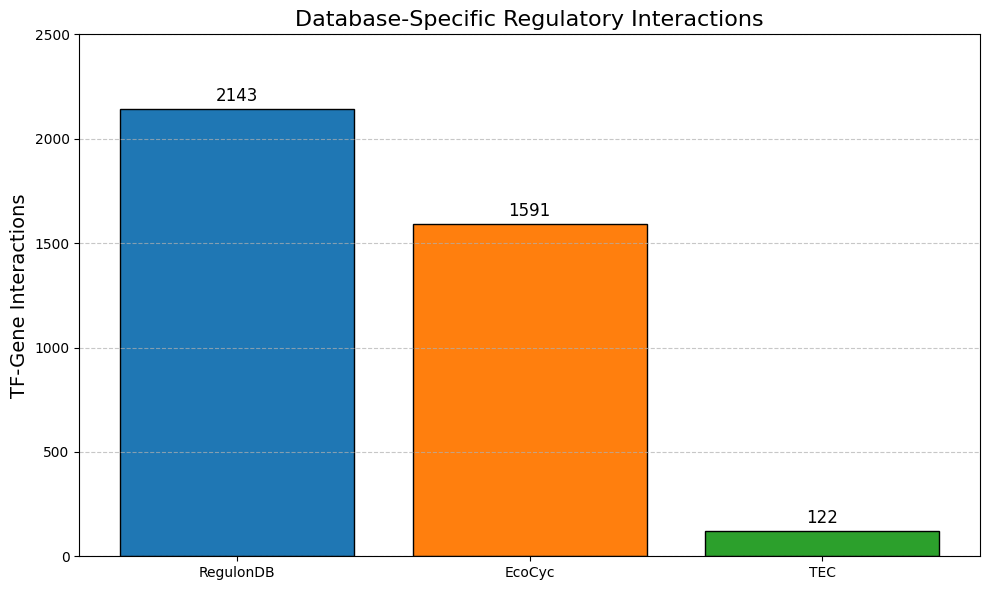

In [4]:
import matplotlib.pyplot as plt
import numpy as np

databases = ['RegulonDB', 'EcoCyc', 'TEC']
interactions = [2143, 1591, 122]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(10, 6))
bars = plt.bar(databases, interactions, color=colors, edgecolor='black')

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)

plt.ylabel('TF-Gene Interactions', fontsize=14)
plt.title('Database-Specific Regulatory Interactions', fontsize=16)
plt.ylim(0, 2500)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('database_comparison.png', dpi=300)